<a href="https://colab.research.google.com/github/ryanreilly/phase_5_capstone/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
!unzip drive/MyDrive/train.zip
!unzip drive/MyDrive/dev.zip
!unzip drive/MyDrive/test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/not_disaster/1035802906522345473_1.jpg  
  inflating: __MACOSX/test/not_disaster/._1035802906522345473_1.jpg  
  inflating: test/not_disaster/ad_2017-11-25_03-34-48.jpg  
  inflating: __MACOSX/test/not_disaster/._ad_2017-11-25_03-34-48.jpg  
  inflating: test/not_disaster/ad_2017-11-25_08-04-10.jpg  
  inflating: __MACOSX/test/not_disaster/._ad_2017-11-25_08-04-10.jpg  
  inflating: test/not_disaster/969301247344996352_2.jpg  
  inflating: __MACOSX/test/not_disaster/._969301247344996352_2.jpg  
  inflating: test/not_disaster/ad_2017-11-25_12-16-33.jpg  
  inflating: __MACOSX/test/not_disaster/._ad_2017-11-25_12-16-33.jpg  
  inflating: test/not_disaster/935267064691986432_0.jpg  
  inflating: __MACOSX/test/not_disaster/._935267064691986432_0.jpg  
  inflating: test/not_disaster/ad_2017-11-25_03-05-40.jpg  
  inflating: __MACOSX/test/not_disaster/._ad_2017-11-25_03-05-40.jpg  
  inflating: test/not_disaster/building_20

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul 22 22:43:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
train_dir = 'train'
validation_dir = 'dev'
test_dir = 'test'

In [4]:
#For manipulating and visualizing images
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#To load an image using Keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import optimizers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model, load_model

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

#to track how long the models run
import datetime

#For dividing the images into correct folders
import shutil
import os

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
            
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator_dense = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(240, 240),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator_dense = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(240, 240), 
                                                              batch_size=32, 
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 12422 images belonging to 7 classes.
Found 1458 images belonging to 7 classes.


In [8]:
Densenet = DenseNet121(
    input_shape= (224,224,3),
    include_top=False,
    weights='imagenet')


Densenet.trainable = False

# Define Model Architecture
X = Densenet.output
X = GlobalAveragePooling2D()(X)
X = BatchNormalization()(X)
X = Dropout(0.5)(X)
X = Dense(1024,activation='relu')(X) 
X = Dense(512,activation='relu')(X) 
X = BatchNormalization()(X)
X = Dropout(0.5)(X)
outputs = Dense(7, activation='softmax')(X)

model_dense = Model(Densenet.input, outputs)


opt = optimizers.Adam(learning_rate=0.00001)
model_dense.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("densenet.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=30, 
                      verbose=1, 
                      mode='auto')

history_6= model_dense.fit_generator(generator= train_generator_dense,
                                    epochs= 30, 
                                    validation_data= validation_generator_dense, 
                                    validation_steps=1, 
                                    callbacks=[checkpoint,early])

Epoch 1/30
389/389 [==============================] - 303s 728ms/step - loss: 2.7282 - accuracy: 0.2163 - val_loss: 1.3765 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to densenet.h5
Epoch 2/30
389/389 [==============================] - 281s 723ms/step - loss: 2.2205 - accuracy: 0.3284 - val_loss: 0.8850 - val_accuracy: 0.7188

Epoch 00002: val_accuracy improved from 0.50000 to 0.71875, saving model to densenet.h5
Epoch 3/30
389/389 [==============================] - 281s 723ms/step - loss: 2.0175 - accuracy: 0.3957 - val_loss: 0.6718 - val_accuracy: 0.7500

Epoch 00003: val_accuracy improved from 0.71875 to 0.75000, saving model to densenet.h5
Epoch 4/30
389/389 [==============================] - 281s 722ms/step - loss: 1.9380 - accuracy: 0.4343 - val_loss: 0.5572 - val_accuracy: 0.7812

Epoch 00004: val_accuracy improved from 0.75000 to 0.78125, saving model to densenet.h5
Epoch 5/30
389/389 [==============================] - 281s 722m

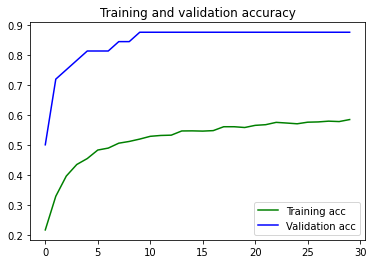

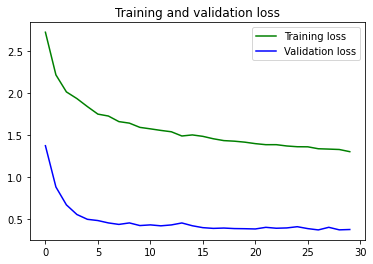

In [9]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
test_generator_dense = test_datagen.flow_from_directory(test_dir, 
                                                              target_size=(224, 224), 
                                                              batch_size=32, 
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 3147 images belonging to 7 classes.


In [12]:
y_pred = model_dense.predict(test_generator_dense, batch_size=32)

In [13]:
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator_dense.classes, y_pred))

Confusion Matrix
[[330   4   5  28   8  19  10]
 [ 23 208   9  22   3  10   5]
 [ 17   9 489  41  13  25   5]
 [ 31  10  56 220  13  12  10]
 [ 27   9  17  22 137   1   7]
 [ 57  24  72  31  17 761  28]
 [ 65  16  28  54  18  45  76]]


In [14]:
print(classification_report(test_generator_dense.classes, y_pred, target_names = [key for key,value in test_generator_dense.class_indices.items()]))

                precision    recall  f1-score   support

    earthquake       0.60      0.82      0.69       404
          fire       0.74      0.74      0.74       280
         flood       0.72      0.82      0.77       599
     hurricane       0.53      0.62      0.57       352
     landslide       0.66      0.62      0.64       220
  not_disaster       0.87      0.77      0.82       990
other_disaster       0.54      0.25      0.34       302

      accuracy                           0.71      3147
     macro avg       0.67      0.66      0.65      3147
  weighted avg       0.71      0.71      0.70      3147



In [20]:
cm = confusion_matrix(test_generator_dense.classes, y_pred)

In [21]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [29]:
def plot_confusion_mat(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
cm_plot_labels = [key for key,value in test_generator_dense.class_indices.items()]

Confusion matrix, without normalization


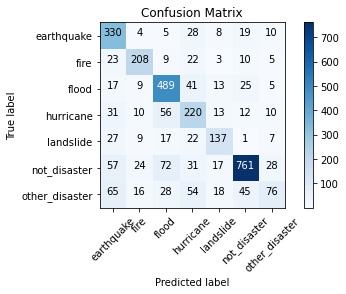

In [32]:
plot_confusion_mat(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')